![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [554]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
import matplotlib.pyplot as plt


In [12]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [16]:
# Celda 1.1
#bikes.groupby('season').total.mean()
bikes.groupby('season')['total'].agg([
    'count', 'mean', 'std', 'min', 
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.5), 
    lambda x: x.quantile(0.75), 
    'max',
    ]).rename(columns={
    '<lambda_0>': 'Percentil 25',
    '<lambda_1>': 'Percentil 50',
    '<lambda_2>': 'Percentil 75',
    })

,count,mean,std,min,Percentil 25,Percentil 50,Percentil 75,max
season,,,,,,,,
1,2686,116.343261,125.273974,1,24.0,78.0,164.0,801
2,2733,215.251372,192.007843,1,49.0,172.0,321.0,873
3,2733,234.417124,197.151001,1,68.0,195.0,347.0,977
4,2734,198.988296,177.622409,1,51.0,161.0,294.0,948


De acuerdo a la metadata de la base de datos, la variable season corresponde a la temporada del año en que fue rentada la bicicleta. En donde cada valor corresponde a:

1: invierno
2: primavera
3: verano
4: Otoño

Según la distribución de los registros de la base de datos, la temporada del año que tiene mayor media de bicicletas rentadas es verano, seguido de primavera, otoño y finalmente invierno. Esto hace sentido dentro del contexto de los datos, dado que en las temporadas del año más despejadas (como verano y primavera) las personas tenderán a transportarse con mayor frecuencia en bicicleta que en otros medios de transporte, mientras que para temporadas como invierno y otoño no se optará tanto por transportarse en bicicleta.

Como se puede observar dentro de las medidas descriptivas generadas para la variable "season":  
- Los datos están balanceados para cada valor que toma season ya que estos oscilan entre 2686 y 2734
- La temporada de invierno tiene la menor desviación estandar (quiere decir que las rentas de bicicletas fueron más constantes entre horas frente a las demás temporadas) pero la diferencia entre el percentil 75 y el máximo es bastante marcada, lo que nos indica que en esta temporada tenemos presentes algunos atípicos altos. Este mismo fenómeno sucede con las demás temporadas pero no en la misma magnitud que en invierno.
- La base de datos es consistente para esta variable ya que no presenta valores en 0, sino el mínimo de rentas para una hora es de 1


In [19]:
# Celda 1.2
#bikes.groupby('hour').total.mean()
bikes.groupby('hour')['total'].agg([
    'count', 'mean', 'std', 'min', 
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.5), 
    lambda x: x.quantile(0.75), 
    'max',
    ]).rename(columns={
    '<lambda_0>': 'Percentil 25',
    '<lambda_1>': 'Percentil 50',
    '<lambda_2>': 'Percentil 75',
    })

,count,mean,std,min,Percentil 25,Percentil 50,Percentil 75,max
hour,,,,,,,,
0,455,55.138462,43.620012,2,24.00,41.0,74.50,283
1,454,33.859031,34.112105,1,11.00,19.0,46.00,168
2,448,22.899554,26.110267,1,5.00,11.0,32.00,119
3,433,11.757506,12.666442,1,3.00,6.0,15.00,66
4,442,6.407240,4.217633,1,3.00,6.0,9.00,28
5,452,19.767699,12.784293,1,8.00,19.0,29.00,57
6,455,76.259341,54.745333,1,24.50,75.0,118.00,213
7,455,213.116484,159.207044,1,63.00,208.0,334.00,596
8,455,362.769231,231.723065,8,133.50,392.0,563.50,839


De acuerdo a la metadata de la base de datos, el campo hour corresponde a la hora del día en que fueron rentadas las bicicletas, teniendo el valor 0 como el periodo del día comprendido entre las 00:00 y las 00:59; y el valor 23 como el periodo comprendido entre las 23:00 y las 23:59.

- Tal como se presentó con la variable "season", para la variable "hour" tenemos que los datos están homogeneamente distribuidos en la base de datos para cada hora del día, ya que el número de registros para cada valor que puede tomar la variable oscila entre 433 y 456.
- En las horas de la madrugada y ya entrada la noche, la media de bicicletas rentadas disminuye considerablemente frente a las demás horas del día, siendo las 4 am la hora del día con menor media de renta de bicicletas.
- La tarde es el horario con mayor media de renta de bicicletas ya que las horas 16,17,18 y 19 son las horas con mayor media (horas pico de demanda). Así mismo, estas mismas horas son las que presentan mayor desviación estándar, lo que nos puede llevar a inferir que dependiendo de la temporada, se presentan mayores rentas de bicicleta.
- Estas mismas horas pico presentan el mayor percentil 75 del rango de horas del día, lo que confirma que estas horas sean las más demandadas estando el 25% de los casos muy por encima del promedio.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

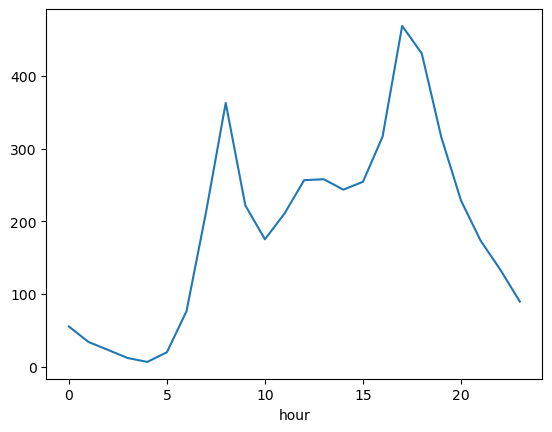

In [23]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

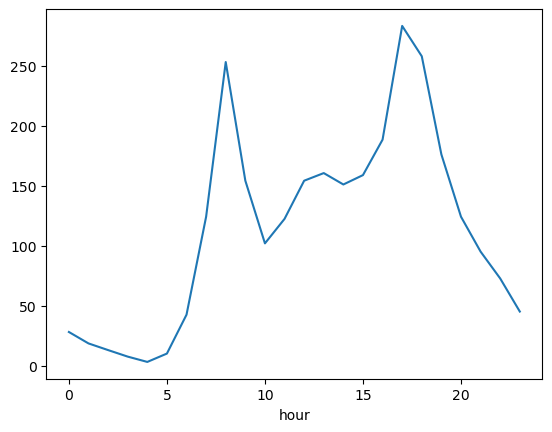

In [25]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

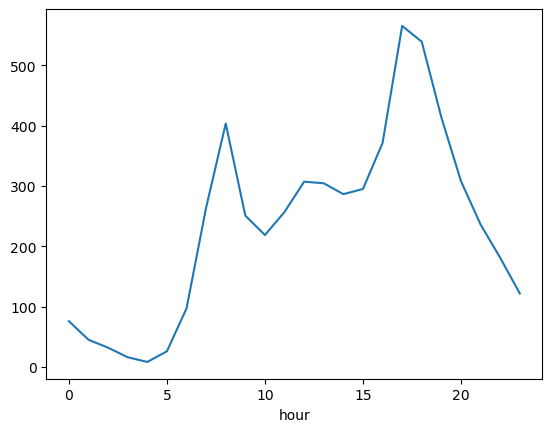

In [27]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()

Como se puede observar en los gráficos, para ambas temporadas (invierno y verano) el patrón de demanda de bicicletas rentadas por hora es el mismo, sin embargo, la media de bicicletas rentada para cada temporada es diferente siendo en verano mucho mayor que en invierno.
Esto nos muestra que el comportamiento de la demanda de bicicletas es idéntico en cada temporada, y esto se puede deber a que se renten las bicicletas para movilizarse al trabajo, estudio o demás actividades rutinarias; pero que dependiendo la temporada, se rentarán con mayor (para el caso del verano) o menor (para el caso del invierno) demanda.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [148]:
# Celda 3
df_lineal = bikes[['season','hour','total']]
df_lineal = pd.get_dummies(df_lineal, columns=['season'], drop_first=True).astype(int)
X_lineal = df_lineal.drop(columns='total')
Y_lineal = df_lineal['total']
XTrain_l, XTest_l, yTrain_l, yTest_l = train_test_split(X_lineal, Y_lineal, test_size=0.33, random_state=0)
modelo_lineal = LinearRegression()
modelo_lineal.fit(XTrain_l, yTrain_l)
prediccion_lineal = modelo_lineal.predict(XTest_l)
MSE_lineal=np.average(np.square(prediccion_lineal-yTest_l))
R2_lineal = modelo_lineal.score(XTest_l,yTest_l)

print(f'los coeficientes del modelo de regresion lineal son: ')
for variable, coef in zip(XTrain_l.columns, modelo_lineal.coef_):
    print(f" {variable}: {coef}")
print(f'El error MSE del modelo de regresión lineal es: {MSE_lineal} \nEl error cuadrado del modelo lineal es: {R2_lineal}') 

los coeficientes del modelo de regresion lineal son: 
 hour: 10.628738853601385
 season_2: 100.9077679258173
 season_3: 119.01866420639179
 season_4: 87.24739029747784
El error MSE del modelo de regresión lineal es: 25644.421108938277 
El error cuadrado del modelo lineal es: 0.21517712032533343


En el procedimiento anterior, primero se seleccionaron las variables a trabajar en el modelo: 'season','hour','total'. Posterior a esto se convirtió a dummie la variable categórica 'season' para poderla trabajar dentro de un modelo de regresión lineal excluyendo la primer temporada 'invierno' para así evital la multicolinealidad entre las variables predictoras. 
Se separá el conjunto de datos en muestras de train y test para poder evaluar el desempeño del modelo, se construye el modelo y finalmente se calculan métricas de error e imprimen coeficientes del modelo.

A partir de los coeficientes resultantes del modelo, podemos interpretar

- Por cada hora que el día avanza, y mientras las demás variables permanezcan constantes, en promedio se rentarán 10 bicicletas
- Al realizar la conversión de la variable "season" y eliminar de las variables la estación invierno, los coeficientes de las variables season_2, season_3 y season_4, representan el impacto adicional de cada una de ellas frente a la variable total comparado con invierno. Dicho esto, frente a la temporada invierno, si las demás variables permanecen constantes, el impacto adicional de la estación primavera sobre el número de bicicletas rentadas es de 100.9.
- Frente a la temporada invierno, si las demás variables permanecen constantes, el impacto adicional de la estación verano sobre el número de bicicletas rentadas es de 119.01.
- Frente a la temporada invierno, si las demás variables permanecen constantes, el impacto adicional de la estación otoño sobre el número de bicicletas rentadas es de 87.2.
- Los coeficientes de las variables  season_2, season_3 y season_4, al ser positivas, confirman inferencias hechas en el análisis descriptivo, en el sentido que en la estación invierno es cuando menos se rentan bicicletas, y las estaciones en las que más se rentan con verano y primavera (con coeficientes más altos).

Limitaciones del modelo de regresión lineal:

- Como se pudo observar en el análisis descriptivo, la relación entre la variable hour y total, no es necesariamente lineal ya que se observan picos y patrones de demanda que no se ajustan a un modelo lineal y limitan la capacidad de predicción dle modelo.
- Aunque los coeficientes de las variables predictoras confirman ciertas inferencias hechas en el análisis descriptivo ( como que la estación invierno es cuando menos se rentan bicicletas, y las estaciones en las que más se rentan con verano y primavera) la relación entre estas interacciones no obedece únicamente a una relación lineal. El modelo lineal simplifica demasiado la interacción de las estaciones frente al número de bicicletas rentadas
- El error cuadrado tan bajo (21.5%) confirma que el modelo lineal solamente puede explicar el 21% del comportamiento de la variable total. No es capaz de explicar el 79% del comportamiento de la variable.
- El error MSE de 25,644 cuando la media de la variable a predecir es 191.5, su percentil 75 es de 284 y su máximo de 977, confirma la baja capacidad que tiene el modelo para explicar las interacciones entre las variables predictoras y la variable a predecir.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [231]:
df_arbol_manual = bikes[['season','hour','total']]
X_arbol = df_arbol_manual.drop(columns='total')
Y_arbol = df_arbol_manual['total']
XTrain_a, XTest_a, yTrain_a, yTest_a = train_test_split(X_arbol, Y_arbol, test_size=0.33, random_state=0)

Se separan las muestras en Train y Test para poderlas utilizar en el modelo y luego evaluar la capacidad de predicción del modelo

In [391]:
def mse_min(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    if n_l == 0 or n_r == 0:
        return 0
    
    mse_y = y.var()
    mse_l = y_l.var() if n_l > 0 else 0
    mse_r = y_r.var() if n_r > 0 else 0

    mse_min_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    return mse_min_

Se crea la función mse_min que lo que hará es calcular el error mse para cada división que se haga en la función best_split.

In [393]:
def best_split(X, y):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:    
        splits = np.unique(X.iloc[:, j])[:-1]
        # Para cada partición
        for split in splits:
            gain = mse_min(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

Se crea la función best_split que evaluará todos los posibles valores que pueden tomar las variables predictoras (aunque computacionalmente no es lo recomendable, para el caso de uso del taller en el que se tienen pocos valores para cada variable se hará así) y determinar cuál es el mejor valor para cada variable para hacer la división.

In [370]:
def tree_grow(X, y, level=0,min_gain=0.001, max_depth=None):
    # Si solo es una observación
    if X.shape[0] == 1:
        return None
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() 
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth)
    
    return tree

Se crea la función tree_grow que creará el árbol de decisión para realizar la predicción de la variable total. De igual forma utiliza los criterios de parada min_gain y max_depth.

In [368]:
def conteo_arbol(tree):
    if tree['split'] == -1:  
        return 1
    return conteo_arbol(tree['sl']) + conteo_arbol(tree['sr'])

Se crea la función conteo_arbol para contar cuántos nodos finales tiene el árbol creado en tree_grow.

In [401]:
def arbol_nodos(X, Y, level, min_gain, max_depth):
    nodos_finales = 0
    while nodos_finales < 6:
        tree = tree_grow(X, Y, level, min_gain, max_depth)
        nodos_finales = conteo_arbol(tree)
        if nodos_finales < 6 and max_depth is not None:
            max_depth += 1
    return tree,max_depth

Se crea la función arbol_nodos para ajustar el parámetro max_depth definido por el usuario, en caso que con el max_depth definido no se alcance el mínimo de nodos finales definidos, se aumentará una unidad del max_depth hasta que se cumpla el criterio.

In [471]:
resultado = arbol_nodos(XTrain_a, yTrain_a, level=0, min_gain=0.001, max_depth=1)
arbol = resultado[0]
max_depth_recalculado = resultado[1]

Se corre el arbol de decisión manual para la regresión.

In [473]:
max_depth_recalculado

3

In [475]:
arbol

{'y_pred': 189.627313862608,
 'level': 0,
 'split': [1, 7],
 'n_samples': 7293,
 'gain': 10266.417356290967,
 'sl': {'y_pred': 32.450256889304065,
  'level': 1,
  'split': [1, 1],
  'n_samples': 2141,
  'gain': 88.75900800081376,
  'sl': {'y_pred': 55.41157556270097,
   'level': 2,
   'split': [0, 2],
   'n_samples': 311,
   'gain': 262.62545348714616,
   'sl': {'y_pred': 27.531645569620252,
    'level': 3,
    'split': -1,
    'n_samples': 79,
    'gain': 0},
   'sr': {'y_pred': 64.90517241379311,
    'level': 3,
    'split': -1,
    'n_samples': 232,
    'gain': 6.489658294854962}},
  'sr': {'y_pred': 28.54808743169399,
   'level': 2,
   'split': [1, 5],
   'n_samples': 1830,
   'gain': 178.3422260573268,
   'sl': {'y_pred': 19.000824402308325,
    'level': 3,
    'split': -1,
    'n_samples': 1213,
    'gain': 95.035785609615},
   'sr': {'y_pred': 47.31766612641815,
    'level': 3,
    'split': -1,
    'n_samples': 617,
    'gain': 137.76945720358935}}},
 'sr': {'y_pred': 254.944875

In [457]:
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [477]:
prediccion_arbol_manual = tree_predict(XTest_a,arbol)
MSE_arbol_manual=np.average(np.square(prediccion_arbol_manual-yTest_l))
R2_arbol_manual = arbol_skl.score(XTest_l,yTest_l)
print(f'El error MSE del modelo de árbol de decisión manual es: {MSE_arbol_manual} \nEl error cuadrado del modelo árbol de decisión manual es: {R2_arbol_manual}') 

El error MSE del modelo de árbol de decisión manual es: 17793.090291537384 
El error cuadrado del modelo árbol de decisión manual es: 0.5897774847423695


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [487]:
# Celda 5
max_depth_range = range(1, 10)
max_features_range = range(1,10)
accuracy_scores = []

for depth in max_depth_range:
    for feature in max_features_range:
        clf = DecisionTreeRegressor(max_depth=depth, max_features=feature, random_state=1)
        score = cross_val_score(clf, XTrain_l, yTrain_l, cv=10, scoring='r2').mean()
        accuracy_scores.append((depth, feature, score))
accuracy_scores = np.array(accuracy_scores)

In [172]:
# Encontrar el índice del valor máximo en score_values
max_score = np.argmax(accuracy_scores)
mejor_depth = accuracy_scores[:, 0][max_score].astype(int)
mejor_feature = accuracy_scores[:, 1][max_score].astype(int)
mejor_score = accuracy_scores[:, 2][max_score]
print(f"Mejor score: Max Depth = {best_depth}, Max Features = {best_feature}, Score = {best_score}")

Mejor score: Max Depth = 9.0, Max Features = 2.0, Score = 0.6074003662248549


In [150]:
arbol_skl = DecisionTreeRegressor(max_depth=mejor_depth, max_features=mejor_feature, random_state=1)
arbol_skl.fit(XTrain_l,yTrain_l)
prediccion_arbol_skl = arbol_skl.predict(XTest_l)

In [439]:
MSE_arbol_skl=np.average(np.square(prediccion_arbol_skl-yTest_l))
R2_arbol_skl = arbol_skl.score(XTest_l,yTest_l)
print(f'El error MSE del modelo de árbol de decisión con sklearn es: {MSE_arbol_skl} \nEl error cuadrado del modelo árbol de decisión con sklearn es: {R2_arbol_skl}') 

El error MSE del modelo de árbol de decisión con sklearn es: 13404.195012759272 
El error cuadrado del modelo árbol de decisión con sklearn es: 0.5897774847423695


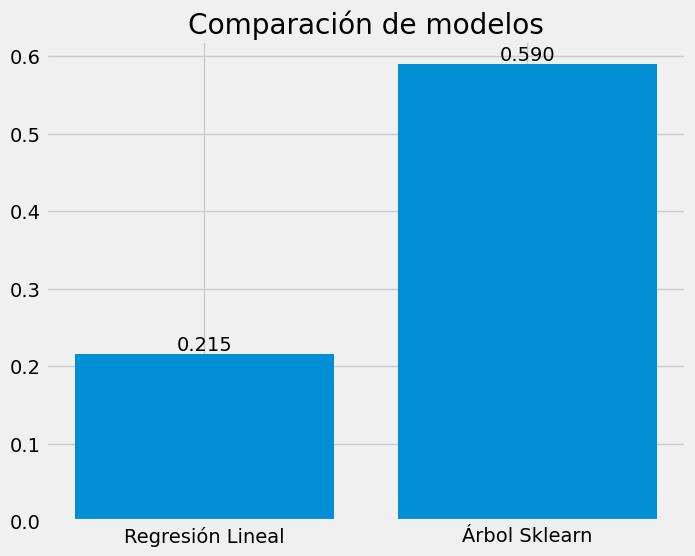

In [176]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['Regresión Lineal','Árbol Sklearn']
ejeY = [R2_lineal,R2_arbol_skl]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        ax.text(i, y[i], f'{y[i]:.3f}', ha='center', va='bottom')
addlabels(ejeX,ejeY,plt)
plt.show()

Con base en la calibración del árbol de decisión con Skitlearn, obtenemos que los mejores parámetros para depth y feature son 9 y 2 respectivamente. Construyendo el modelo con estos parámetros y evaluando el mismo con los datos de test, encontramos que el desempeño del modelo mejora considerablemente frente a la regresión lineal en términos del R cuadrado y del MSE pues se pasa de un 0.21 a 0.59 y de un 25644 a 13404 respectivamente. 
Estos resultados demuestran que el árbol de decisión explica mejor el comportamiento de la variable total, aunque aún sigue siendo un modelo que se queda corto en su desempeño.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [479]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [481]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [483]:
# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [808]:
y_train.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
Popular,,
0,2256,0.501333
1,2244,0.498667


### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [556]:
# Celda 6
max_features_range = range(1,10)
accuracy_scores = []
for features in max_features_range:
    clf = DecisionTreeClassifier(max_features=features, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
max_features_opt = max_features_range[np.argmax(accuracy_scores)]

models = {'dt' : DecisionTreeClassifier(max_features=max_features_opt),
          'lr' : LogisticRegression()}
y_pred = pd.DataFrame(index=y_test.index, columns=models.keys())
results = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'F1-Score'])
for model in models.keys():     
    models[model].fit(X_train,y_train)
    y_pred[model] = models[model].predict(X_test)
    acc = accuracy_score(y_test, y_pred[model])
    f1 = f1_score(y_test, y_pred[model])
    results.loc[model] = [acc, f1]
print(results)

    Accuracy  F1-Score
dt  0.556667  0.561056
lr  0.614667  0.612081


En el procedimiento anterior, se calibra un modelo de árbol de decisión con base en los datos x y y train. Posterior a esto se construyen dos modelos: uno de árbol de decisión (con el parámetro max_features calibrado) y una regresión logística. A partir de la construcción de los modelos, se evalúan con las métricas Accuracy y F1-Score obteniendo que para el conjunto de datos, el modelo que mejor predice la popularidad de las noticias es la regresión logística con un Accuracy de 0.614 y un F1-Score de 0.612

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [565]:
# Celda 7
n_estimators = 300
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [621]:
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees_1 = {}
for i in range(100):
    trees_1[i] = DecisionTreeClassifier(max_depth=5, random_state=seeds[i])
    trees_1[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
trees_2 = {}
for i in range(100, 200):
    trees_2[i] = DecisionTreeClassifier(min_samples_leaf=8, random_state=seeds[i])
    trees_2[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
regresions = {}
for i in range(200, 300):
    regresions[i] = LogisticRegression(random_state=seeds[i])
    regresions[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [677]:
y_pred_df_1 = pd.DataFrame(index=X_test.index, columns=list(range(100)))
y_pred_df_2 = pd.DataFrame(index=X_test.index, columns=list(range(100,200)))
y_pred_df_3 = pd.DataFrame(index=X_test.index, columns=list(range(200,300)))
for i in range(100):
    y_pred_df_1.iloc[:, i] = trees_1[i].predict(X_test)
for i in range(100):
    y_pred_df_2.iloc[:, i] = trees_2[i+100].predict(X_test)
for i in range(100):
    y_pred_df_3.iloc[:, i] = regresions[i+200].predict(X_test)

In [707]:
y_pred_1 = (y_pred_df_1.sum(axis=1) >= (50)).astype(np.int64)
y_pred_2 = (y_pred_df_2.sum(axis=1) >= (50)).astype(np.int64)
y_pred_3 = (y_pred_df_3.sum(axis=1) >= (50)).astype(np.int64)
accuracy_1 = accuracy_score(y_test, y_pred_1)
accuracy_2 = accuracy_score(y_test, y_pred_2)
accuracy_3 = accuracy_score(y_test, y_pred_3)
f1_1 = f1_score(y_test, y_pred_1)
f1_2 = f1_score(y_test, y_pred_2)
f1_3 = f1_score(y_test, y_pred_3)
results_df = pd.DataFrame({
    "Modelo": ["Árboles (max_depth)", "Árboles (min_samples_leaf)", "Regresión Logística"],
    "Accuracy": [accuracy_1, accuracy_2, accuracy_3],
    "F1-Score": [f1_1, f1_2, f1_3]
})
print(results_df)

                       Modelo  Accuracy  F1-Score
0         Árboles (max_depth)  0.654667  0.652815
1  Árboles (min_samples_leaf)  0.649333  0.647925
2         Regresión Logística  0.618000  0.612051


In [724]:
y_pred_df = pd.concat([y_pred_df_1, y_pred_df_2, y_pred_df_3], axis=1)
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int64)

In [728]:
accuracy =accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1-Score:", f1)

Accuracy: 0.6293333333333333
F1-Score: 0.6227951153324288


In [798]:
results_df.loc[3] = ['Votación Mayoritaria', accuracy, f1]

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [751]:
# Celda 8
samples_oob_1 = []
samples_oob_2 = []
samples_oob_3 = []

for sample in samples[:100]:
    samples_oob_1.append(sorted(set(range(n_samples)) - set(sample)))

for sample in samples[100:200]:
    samples_oob_2.append(sorted(set(range(n_samples)) - set(sample)))

for sample in samples[200:300]:
    samples_oob_3.append(sorted(set(range(n_samples)) - set(sample)))

In [766]:
errors_1 = np.zeros(100)
errors_2 = np.zeros(100)
errors_3 = np.zeros(100)

for i in range(100):
    y_pred_ = trees_1[i].predict(X_train.iloc[samples_oob_1[i]])
    errors_1[i] = 1 - accuracy_score(y_train.iloc[samples_oob_1[i]], y_pred_)

for i in range(100):
    y_pred_ = trees_2[i+100].predict(X_train.iloc[samples_oob_2[i]])
    errors_2[i] = 1 - accuracy_score(y_train.iloc[samples_oob_2[i]], y_pred_)

for i in range(100):
    y_pred_ = regresions[i+200].predict(X_train.iloc[samples_oob_3[i]])
    errors_3[i] = 1 - accuracy_score(y_train.iloc[samples_oob_3[i]], y_pred_)

In [789]:
errors_combined = np.concatenate([errors_1, errors_2, errors_3])
alpha_combined = (1 - errors_combined) / (1 - errors_combined).sum()
y_pred_df_combined = pd.concat([y_pred_df_1, y_pred_df_2, y_pred_df_3], axis=1)
weighted_sum_combined = (y_pred_df_combined * alpha_combined).sum(axis=1)
y_pred_combined = (weighted_sum_combined >= 0.5).astype(np.int64)

accuracy_ponderada = accuracy_score(y_test, y_pred_combined)
f1_ponderada = f1_score(y_test, y_pred_combined)

print(accuracy_ponderada, f1_ponderada)

0.63 0.6227056424201224


In [802]:
results_df.loc[4] = ['Votación Ponderada', accuracy_ponderada, f1_ponderada]

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [804]:
# Celda 9
results_df

,Modelo,Accuracy,F1-Score
0,Árboles (max_depth),0.654667,0.652815
1,Árboles (min_samples_leaf),0.649333,0.647925
2,Regresión Logística,0.618000,0.612051
3,Votación Mayoritaria,0.629333,0.622795
4,Votación Ponderada,0.630000,0.622706


Con base en los resultados obtenidos, se puede concluir:
- Por separado los árboles de decisión tienen un desempeño mejor que la regresión logística y ambos muy similares.
- Cuando se hace el ensamblaje por votacón mayoritaria de los 300 modelos, podemos observar que el bajo desempeño de la regresión logística arrastra el desempeño de los demás modelos
- De la misma manera en el ensamblake por votación ponderada, el efecto que tiene la regresión logística sobre la evaluación de los modelos por separado se presenta pero no tan marcadamente como en la votación matoritaria. Esto se debe principalmente a la capacidad que tiene la votación ponderada para restarle valor a aquellas predicciones con más error
- El modelo con mejor desempeño fue el árbol de decisión con max_depth = 5 realizado con 100 muestras bagged con un accuracy de 0.654 y un F1-Score de 0.652
- En todos los modelos evaluados, el Accuracy y el F1-Score dieron muy similares, lo que corrobora el balanceo de clases que tenia la muestra de datos